In [1]:
# -*- coding: utf-8 -*-
import numpy as np
import pymc as pm
import arviz as az
import pytensor.tensor as at
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

os.chdir(os.getcwd())

In [2]:
# data from Gossner et al (2022)
data = pd.read_csv("dengue_travel_europe.csv")

infected = data["infected travellers"].values.astype("int") 
total = data["total travellers"].values.astype("int")
N = len(data)

data

,country,infected travellers,infection rate travellers,total travellers
0,Thailand,2956.0,19.6,1.508163e+07
1,Indonesia,1139.0,29.0,3.927586e+06
2,Philippines,445.0,12.6,3.531746e+06
3,Vietnam,331.0,10.0,3.310000e+06
4,Cambodia,278.0,45.7,6.083151e+05
...,...,...,...,...
94,Samoa,2.0,99.3,2.014099e+03
95,Melanesia,57.0,24.4,2.336066e+05
96,"New Caledonia, France",37.0,20.4,1.813725e+05
97,Fiji,12.0,29.8,4.026846e+04


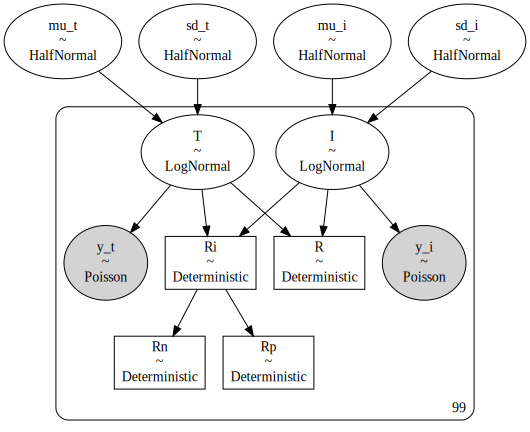

In [3]:
with pm.Model() as mod:
    mu_t = pm.HalfNormal("mu_t", 1)
    sd_t = pm.HalfNormal("sd_t", 1)
    mu_i = pm.HalfNormal("mu_i", 1)
    sd_i = pm.HalfNormal("sd_i", 1)
    I = pm.LogNormal("I", mu_i, sd_i, shape=N) #infected travellers
    T = pm.LogNormal("T", mu_t, sd_t, shape=N) #total travellers 
    y_i = pm.Poisson("y_i", mu=I, observed=infected)
    y_t = pm.Poisson("y_t", mu=T, observed=total)
    R = pm.Deterministic("R", 100000*I/T) #travellers rate of infection per 100000 travellers
    Ri = pm.Deterministic("Ri", (I/(T-I))*T) #raw risk (see Lee et al, 2019), i.e. ratio of infected and healthy travellers by total travellers 
    Rn = pm.Deterministic("Rn", Ri/Ri.max()) #normalised risk
    Rp = pm.Deterministic("Rp", Ri/Ri.sum()) #proportion of risk per country

dag = pm.model_to_graphviz(mod)
dag.render("model_dag", format="png")
dag    

In [5]:
with mod:
    idata = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_t, sd_t, mu_i, sd_i, I, T]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 68 seconds.
Chain <xarray.DataArray 'chain' ()>
array(0)
Coordinates:
    chain    int32 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain <xarray.DataArray 'chain' ()>
array(1)
Coordinates:
    chain    int32 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain <xarray.DataArray 'chain' ()>
array(2)
Coordinates:
    chain    int32 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain <xarray.DataArray 'chain' ()>
array(3)
Coordinates:
    chain    int32 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.


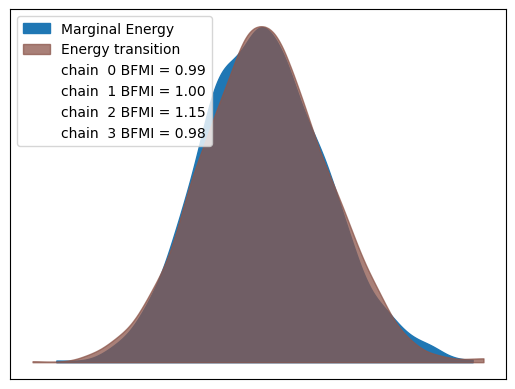

C:\Users\dts-cf924702\Anaconda3\envs\pymc_env\lib\site-packages\arviz\stats\diagnostics.py:584: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,country
mu_t,12.974,0.191,12.616,13.367,0.002,0.001,8421.0,3036.0,1.00,grand
sd_t,1.782,0.130,1.550,2.046,0.002,0.001,8105.0,3364.0,1.00,grand
mu_i,3.105,0.172,2.773,3.448,0.002,0.001,8050.0,2714.0,1.00,grand
sd_i,1.681,0.126,1.443,1.942,0.002,0.001,6112.0,2820.0,1.00,grand
I[0],2954.163,53.663,2850.591,3063.962,0.522,0.370,10602.0,2600.0,1.00,Thailand
...,...,...,...,...,...,...,...,...,...,...
Rp[94],0.000,0.000,0.000,0.001,0.000,0.000,9806.0,2650.0,1.00,Samoa
Rp[95],0.005,0.001,0.004,0.006,0.000,0.000,7667.0,2662.0,1.00,Melanesia
Rp[96],0.003,0.001,0.002,0.004,0.000,0.000,9320.0,2767.0,1.01,"New Caledonia, France"
Rp[97],0.001,0.000,0.001,0.002,0.000,0.000,8813.0,3116.0,1.00,Fiji


In [6]:
pos = idata.stack(sample = ['chain', 'draw']).posterior

az.plot_energy(idata)
plt.savefig("energy.png", dpi=300)
plt.show()
plt.close()

summ = az.summary(idata, hdi_prob=0.95)
summ['country'] = ["grand","grand","grand","grand"] + list(np.tile(data.country.values, 6))
summ.to_csv("summary.csv")
summ

In [ ]:
az.plot_trace(idata.posterior, var_names=["I", "T", "R"], kind="rank_vlines")
plt.tight_layout()
plt.savefig("rank_plots.png", dpi=300)
plt.show()
plt.close()

az.plot_pair(idata.posterior, var_names=["Ri"], kind=["scatter", "kde"], marginals=True)
plt.tight_layout()
plt.savefig("pair_plots_Ri.png", dpi=300)
plt.close()

az.plot_pair(idata.posterior, var_names=["Rp"], kind=["scatter", "kde"], marginals=True)
plt.tight_layout()
plt.savefig("pair_plots_Rp.png", dpi=300)
plt.show()
plt.close()

C:\Users\dts-cf924702\AppData\Local\Temp\ipykernel_4132\2843567073.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = [mpl.cm.get_cmap('autumn')(x/24) for x in range(24)][:18]


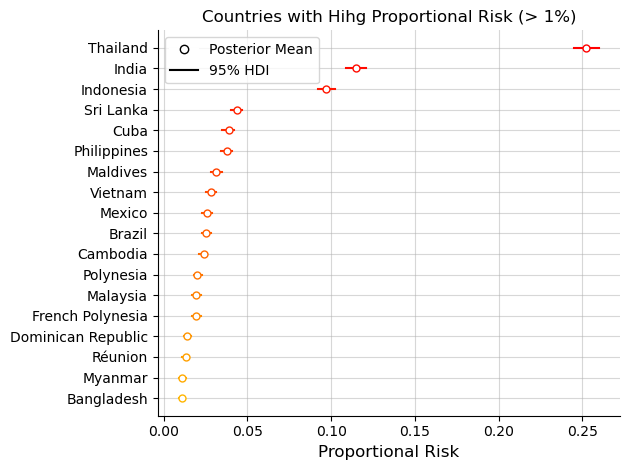

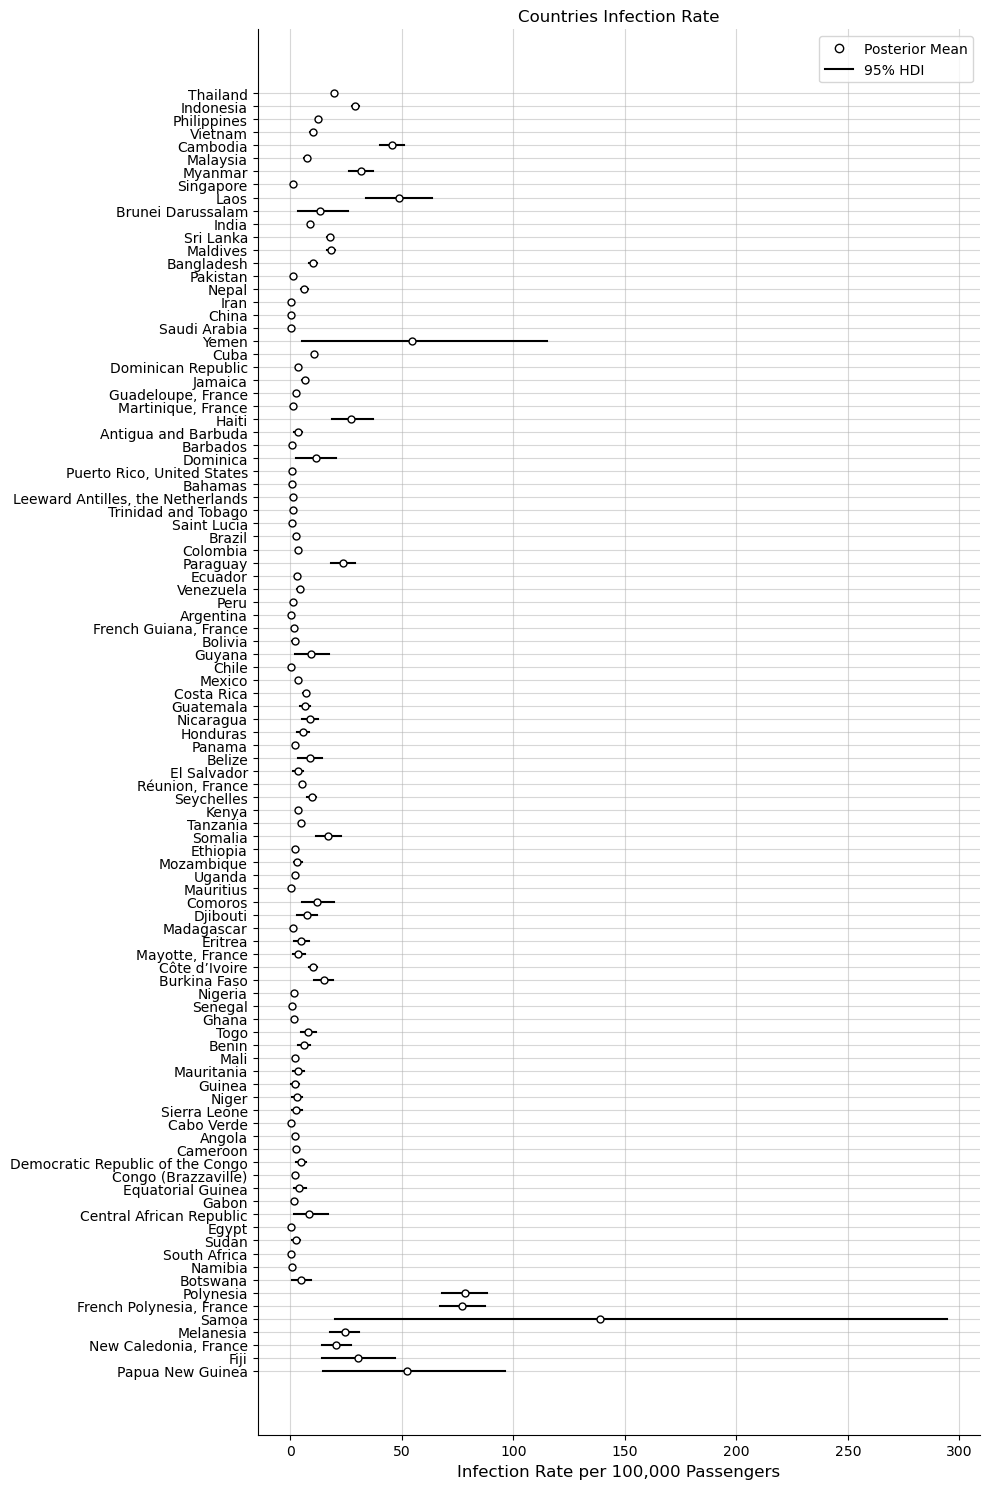

In [7]:
rph = summ[summ.index.str.contains("Rp")]
rph = rph[rph["mean"] > 0.01] #only countries with over 1% risk
rph = rph.sort_values("mean", ascending=False)
names = [rph.country[c].split(",")[0] for c in range(len(rph))]

colors = [mpl.cm.get_cmap('autumn')(x/24) for x in range(24)][:18]
fig, ax = plt.subplots()
for i in range(len(rph)):
    ax.plot((rph["hdi_2.5%"][i], rph["hdi_97.5%"][i]), (17-i, 17-i), color=colors[i])
    ax.plot(rph["mean"][i], 17-i, marker="o", markersize=5, markerfacecolor="w", color=colors[i])
    ax.set_yticks(list(np.flip(np.arange(18))), names)
    ax.spines[['right', 'top']].set_visible(False)
    ax.set_xlabel("Proportional Risk", size=12)
    ax.grid(alpha=0.5)
    ax.set_title("Countries with Hihg Proportional Risk (> 1%)")
line = mpl.lines.Line2D([], [], color='k', label='95% HDI')
circle = mpl.lines.Line2D([], [], color='w', marker='o', markeredgecolor='k', label='Posterior Mean')
ax.legend(handles=[circle, line], loc="lower right")
plt.tight_layout()    
plt.savefig("proportional_risk.png", dpi=300)
plt.show()
plt.close()

rs = ["R["+str(i)+"]" for i in range(99)]
rinf = summ[summ.index.isin(rs)]
fig, ax = plt.subplots(figsize=(10,15))
for i in range(len(rinf)):
    ax.plot((rinf["hdi_2.5%"][i], rinf["hdi_97.5%"][i]), (98-i, 98-i), color="k")
    ax.plot(rinf["mean"][i], 98-i, marker="o", markersize=5, markerfacecolor="w", color="k")
    ax.set_yticks(list(np.flip(np.arange(99))), rinf.country.values)
    ax.spines[['right', 'top']].set_visible(False)
    ax.set_xlabel("Infection Rate per 100,000 Passengers", size=12)
    ax.grid(alpha=0.5)
    ax.set_title("Countries Infection Rate")
line = mpl.lines.Line2D([], [], color='k', label='95% HDI')
circle = mpl.lines.Line2D([], [], color='w', marker='o', markeredgecolor='k', label='Posterior Mean')
ax.legend(handles=[circle, line])
plt.tight_layout()    
plt.savefig("infection_rate.png", dpi=300)
plt.show()
plt.close()

In [8]:
###
#drawbacks: lack of timeline, so cannot tell exposed from not exposed and time-periods
###

'''
References

Lee H, Kim Y, Kim E, ‍Lee S, Risk Assessment of Importation and Local Transmission 
of COVID-19 in South Korea: Statistical Modeling Approach JMIR Public Health 
Surveill 2021;7(6):e26784, doi: 10.2196/26784

Gossner CM, Fournet N, Frank C, Fernández-Martínez B, Del Manso M, Gomes Dias J, 
de Valk H. Dengue virus infections among European travellers, 2015 to 2019. 
Euro Surveill. 2022 Jan;27(2):2001937. doi: 10.2807/1560-7917

'''

'\nReferences\n\nLee H, Kim Y, Kim E, \u200dLee S, Risk Assessment of Importation and Local Transmission \nof COVID-19 in South Korea: Statistical Modeling Approach JMIR Public Health \nSurveill 2021;7(6):e26784, doi: 10.2196/26784\n\nGossner CM, Fournet N, Frank C, Fernández-Martínez B, Del Manso M, Gomes Dias J, \nde Valk H. Dengue virus infections among European travellers, 2015 to 2019. \nEuro Surveill. 2022 Jan;27(2):2001937. doi: 10.2807/1560-7917\n\n'